In [25]:
pip install torchtext

     |████████████████████████████████| 1.8 MB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 137.6 MB 1.8 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.7.1
    Uninstalling torch-1.7.1:
      Successfully uninstalled torch-1.7.1
Note: you may need to restart the kernel to use updated packages.


In [144]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.model_selection import train_test_split

In [5]:
data = pd.read_excel('Data/SemEval-2015-Scraped.xlsx')[['content', 'label']]

<AxesSubplot:ylabel='Density'>

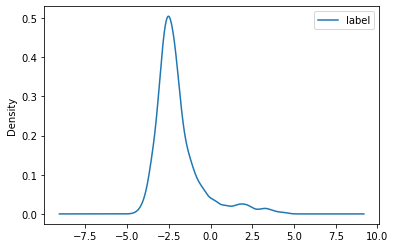

In [7]:
data.plot.kde()

In [11]:
labels = data.label.to_numpy()
print(np.mean(labels),np.std(labels))

-1.9915125 1.3768921934355465


In [19]:
import torch
import random

SEED = 2022

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [71]:
from transformers import BertTokenizer, BertModel

In [21]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [40]:
tokenizer('I love it 😄')

{'input_ids': [101, 1045, 2293, 2009, 100, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [22]:
# Load the special tokens and configurations
init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']


In [ ]:
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2]
    return tokens

In [205]:
X,y = data['content'].values, pd.concat([data['label'] >= 0, data['label'] < 0], axis = 1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
print(f'shape of train data is {X_train.shape}')
print(f'shape of test data is {X_test.shape}')

shape of train data is (6000,)
shape of test data is (2000,)


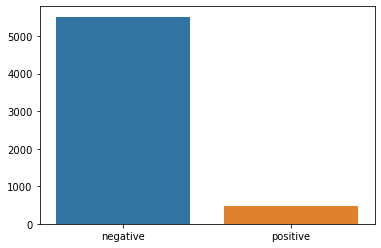

In [81]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [199]:
def preprocess_string(s):
    # This cleans out all emojis!!!
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tokenize(x_train,y_train,x_val,y_val):
#     word_list = []

#     stop_words = set(stopwords.words('english')) 
#     for sent in x_train:
#         for word in sent.lower().split():
#             word = preprocess_string(word)
#             if word not in stop_words and word != '':
#                 word_list.append(word)
  
#     corpus = Counter(word_list)
#     # sorting on the basis of most common words
#     corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
#     # creating a dict
#     onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
#     # tockenize
#     final_list_train,final_list_test = [],[]
#     for sent in x_train:
#             final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
#                                      if preprocess_string(word) in onehot_dict.keys()])
#     for sent in x_val:
#             final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
#                                     if preprocess_string(word) in onehot_dict.keys()])
    final_list_train, final_list_test = [], []
    for sent_1 in x_train:
        final_list_train = tokenizer(preprocess_string(sent_1))
    for sent_2 in x_val:
        final_list_test = tokenizer(preprocess_string(sent_2))
        
    encoded_train = [1 if label == True else 0 for label in y_train]  
    encoded_test = [1 if label == True else 0 for label in y_val]
    
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test)

In [57]:
token_lens = []

for txt in data['content']:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/Users/balechen/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


77


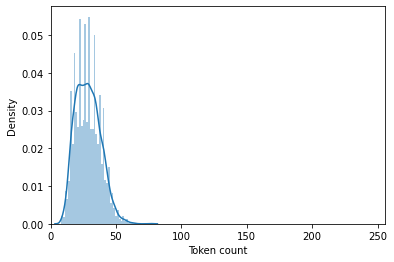

In [60]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');
print(max(token_lens))

In [211]:
class TweetDataset(Dataset):

    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweets = str(self.tweets[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          tweets,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'tweet_text': tweets,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.float32)
        }

In [212]:
def create_data_loader(X, y, tokenizer, max_len, batch_size):
    ds = TweetDataset(
    tweets=X,
    targets=y,
    tokenizer=tokenizer,
    max_len=max_len
    )

    return DataLoader(
    ds,
    batch_size=batch_size)

In [213]:
BATCH_SIZE = 16
MAX_LEN = 128

train_data_loader = create_data_loader(X_train, y_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(X_test, y_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [214]:
len(train_data_loader)

375

In [215]:
dataiter = iter(train_data_loader)
sample = dataiter.next()
print(sample.keys())
print(sample['input_ids'].shape)
print(sample['attention_mask'].shape)
print(sample['targets'].shape)

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16, 2])


## Model

In [72]:
bert = BertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [124]:
trial = nn.LSTM(input_size=768,
       hidden_size=512,
       num_layers=2,
       bidirectional=True,
       batch_first=True)
hidden = trial(bert(input_ids=sample['input_ids'],
          attention_mask=sample['attention_mask'])[0])[1][0]

In [132]:
torch.flatten(hidden.transpose(0,1), start_dim = 1, end_dim= 2).shape

torch.Size([16, 2048])

In [230]:
class BERT_BiLSTM_FFF_Cls(nn.Module):

    def __init__(self, bert, hidden_dim, bidirectional):
        super(BERT_BiLSTM_FFF_Cls, self).__init__()
        embedding_dim = bert.config.to_dict()['hidden_size']
        self.hidden_dim = hidden_dim
        self.bert = bert
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(input_size=embedding_dim,
                           hidden_size=self.hidden_dim,
                           num_layers=2,
                           bidirectional=self.bidirectional,
                           batch_first=True)
        
        self.drop = nn.Dropout(p=0.25)
        
        self.out = nn.Sequential(
                    nn.Linear(self.hidden_dim * 4, 512),
                    nn.ReLU(),
                    nn.Linear(512, 2)
                   )

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            embeddings = self.bert(
              input_ids=input_ids,
              attention_mask=attention_mask
            )[0]
        
        last_hidden = self.lstm(embeddings)[1][0]
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        last_hidden = self.drop(torch.flatten(last_hidden.transpose(0,1), start_dim=1, end_dim=2))
        
        return self.out(last_hidden)

In [154]:
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [231]:
hidden_dim = 512
bidirectional = True
EPOCHS = 10
lr=0.001
device = 'cpu'

baseline_1 = BERT_BiLSTM_FFF_Cls(bert, hidden_dim, bidirectional)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(baseline_1.parameters(), lr=lr)


## Training 

In [235]:
#TODO
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )
#         print(outputs.dtype)
        _,preds = torch.max(outputs, dim = 1)
        loss = loss_fn(outputs, targets)
#         prediction_error += torch.sum(torch.abs(targets - outputs))
        correct_predictions += torch.sum(preds == torch.max(targets, dim = 1)[1])
        print(f'Iteration loss: {loss.item()}')
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [236]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
#             prediction_error += torch.sum(torch.abs(targets - outputs))
            loss = loss_fn(outputs, targets)
            
            correct_predictions += torch.sum(preds == torch.max(targets, dim = 1)[1])
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [237]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
    baseline_1,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device,
    len(X_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
    baseline_1,
    test_data_loader,
    loss_fn, 
    device, 
    len(X_test)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Iteration loss: 0.6581528782844543
Iteration loss: 0.2489658147096634
Iteration loss: 0.034000977873802185
Iteration loss: 0.23711805045604706
Iteration loss: 0.2582758367061615
Iteration loss: 0.43270736932754517
Iteration loss: 0.6810256242752075
Iteration loss: 0.23610123991966248
Iteration loss: 0.24646008014678955
Iteration loss: 0.3821446895599365
Iteration loss: 0.24431005120277405
Iteration loss: 0.1087142676115036
Iteration loss: 0.5054947733879089
Iteration loss: 0.373274028301239
Iteration loss: 0.1337800770998001
Iteration loss: 0.3670923113822937
Iteration loss: 0.4981868267059326


KeyboardInterrupt: 